# Example: Compute the Probability of Profit and Exercise for a Call Contract
In this example, we'll compute the Probability of Profit (POP) for a __short__ call option contract.

__Scenario:__ Suppose we sold a call option on TSLA. Let's use options data and projections of the TSLA share price to compute the breakeven point for the contract, i.e., the value of the TSLA share price where you (the seller) begin to lose money,the probability of profit (POP), and the probability of exercise of the contract.

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * __Calculate breakeven points for call option contracts:__ Compute the share price at expiration where the option position transitions from profit to loss for both buyers and sellers.
> * __Project future share price distributions using two methods:__ Use the GBM model with risk-neutral drift and volatility parameters to generate log-normal distributions, and construct a Normal distribution using implied volatility for quick estimates.
> * __Estimate probability of profit using cumulative distribution functions:__ Apply the CDF of the projected share price distribution to calculate the likelihood of profitable outcomes from buyer and seller perspectives.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

<div>
    <center>
        <img src="figs/Fig-TSLA-Option-Data-11-3-2025.png" width="800"/>
    </center>
</div>

### Data
Let's set some values for the parameters and constants we will use in this example.

__Data:__ We gathered TSLA contract data at 10:41 am (BOS time) on `11-03-2025`. In this example, we'll use options pricing data for a DTE = 46-day call option on [Tesla](https://finance.yahoo.com/quote/TSLA/) as the underlying asset (ticker `TSLA`), with a strike price of K = 485.0 USD/share. The `TSLA` close price was $S_{0}$ = 471.47 USD/share. The probability of profit for this contract is `70.63%` from the seller's perspective and `29.36%` from the buyer's perspective.

Let's set the parameters for this contract so we can use them below:

In [7]:
DTE = 46.0; # days to expiration
Sₒ = 471.47; # TSLA underlying share price USD/share
IV = 58.38; # implied volatility
Δt = (1/365); # Time step 1-trading day
K = 485.0; # strike price for call contract
P = 34.23; # mark premium
B = 519.23; # observed midpoint price for call contract
POP = 0.7063; # probability of profit for short call
risk_free_rate = 0.0431; # yield 10-year treasury note on 11-03-2025
h = 366; # number of levels in the tree

Next, we construct contract models for the options in this example. We begin by building an instance of the [MyAmericanCallContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) using the [custom build(...) method for this type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}). 

The [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}) takes two arguments: the type of thing we want to build, and a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) containing the strike price $K$, the premium paid for the option, the days to expiration `DTE` (units: years), the `sense` = 1 (long), the number of contracts in the `copy` field and the (decimal) implied volatility (IV) in the `IV` field.

We save the call option contract model in the `call_option_model::MyAmericanCallContractModel` variable:

In [9]:
call_option_model = build(MyAmericanCallContractModel, (
    K = K, 
    premium = P, # mark price
    DTE = (DTE)*Δt,
    sense = 1, # compute greeks of long contract
    copy = 1,
    IV = (IV/100)
)); # contract variables: accessed at 10:41 am (BOS time) on 11-03-2025

In this example, we'll need to do a projection of the future share price distribution at the contract's expiration date. We'll use a Geometric Brownian Motion (GBM) model to project the future share price distribution at expiration.

Let's load the single asset geometric Brownian motion (SAGBM) parameters which we estimated a few lectures ago, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [11]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

What's in `parameters_df::DataFrame`?

In [13]:
parameters_df

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,A,0.147468,1.96,0.145161,0.149774,0.231426
2,AAL,-0.141294,1.96,-0.1436,-0.138988,0.454992
3,AAP,-0.0481021,1.96,-0.0504085,-0.0457958,0.342562
4,AAPL,0.24271,1.96,0.240403,0.245016,0.234474
5,ABBV,0.116,1.96,0.113693,0.118306,0.242938
6,ABT,0.123083,1.96,0.120777,0.125389,0.199723
7,ACN,0.151012,1.96,0.148706,0.153319,0.214367
8,ADBE,0.224401,1.96,0.222094,0.226707,0.276273
9,ADI,0.146449,1.96,0.144142,0.148755,0.259329


___

## Task 1: Compute the break-even points for long and short TSLA calls
In this task, we'll compute the breakeven price of a short `TSLA` call contract. The breakeven at expiration for both a long or short call contract is the share price $B_{c}(T)$ at expiration such that $P_{c}(K, B_{c}(T)) = 0$. Thus, for our `TSLA` call, the breakeven share price $B_{c}$ USD/share would be:
$$
\begin{align*}
B_{c} &= K + \mathcal{P}_{c}(K,S(0))
\end{align*}
$$
For the buyer to make money, the share price must be above the breakeven price $B_{c}$. For the seller to make money, the share price must remain below the breakeven price.

`Unhide` the code block below to see how we plotted the profit diagram at expiration for long and short call positions on the `TSLA` contract:

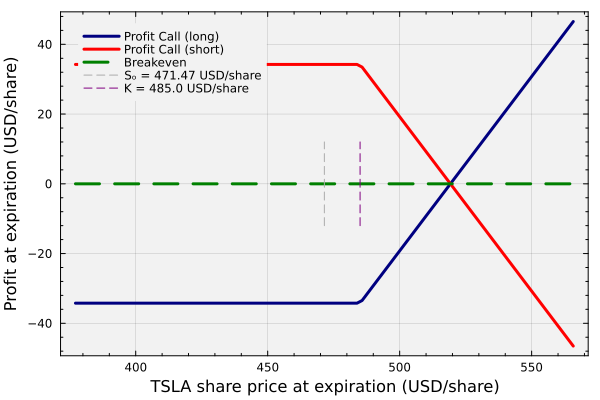

In [16]:
let
    N = 100; # how many points do we want?
    β = range(0.8,stop=1.2, length=N) |> collect;
    ST = Sₒ.*β; # future share price at expiration
    θ = -1; # we are in the short position

    # compute the payoff of the contract -
    payoff_array_long = payoff([call_option_model], ST); # this is always computed for a LONG contract
    profit_array_long = payoff_array_long[:,3] .- P;
    profit_array_short = θ*(payoff_array_long[:,3] .-P);

    # zero line -
    ZL = zeros(N);

    # initial share price line -
    SPL_vertical = range(-12,stop=12,length=N) |> collect;
    SPL_horizontal = Sₒ*ones(N);
    STRIKE_horizontal = K*ones(N);

    # let's visualize
    plot(payoff_array_long[:,1], profit_array_long, c=:navy, lw=3, label="Profit Call (long)", legend=:topleft)
    plot!(payoff_array_long[:,1], profit_array_short, c=:red, lw=3, label="Profit Call (short)")
    plot!(payoff_array_long[:,1],ZL, c=:green, lw=3, ls=:dash, label="Breakeven")
    plot!(SPL_horizontal, SPL_vertical, lw=1,c=:gray67,ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    plot!(STRIKE_horizontal, SPL_vertical, lw=1,c=:purple,ls=:dash, label="K = $(K) USD/share")
    xlabel!("TSLA share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit at expiration (USD/share)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, 
        fg_legend = :transparent, xminorticks = true, yminorticks = true);
end

Compute the break-even price for the call contract and store this in the `computed_breakeven_price::Float64` variable:

In [18]:
computed_breakeven_price = K + P

519.23

### Check: Are the computed and observed breakeven points equal?
The breakeven share price was reported in the dataset: ${B}_{c}=$ `519.23 USD/share`. Confirm the `computed_breakeven_price` by comparing this value with the reported value using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [Julia isapprox(...) function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox).

> __Test:__ If the observed and `computed_breakeven_price` are _not_ approximately equal to some relative tolerance (specified in the `rtol` argument), then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

So what do we get?

In [20]:
@assert isapprox(B, computed_breakeven_price, rtol=1e-3)

___

## Task 2: Construct a single asset GBM model of TSLA share price
In this task, we'll use geometric Brownian motion to compute the distribution of future share prices at expiration $S(T)$ of the call contract. Despite a few shortcomings, a nice feature of geometric Brownian motion is that it has a convenient analytical solution:
$$
\begin{equation*}
S_{t} = S_{0}\;\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{0}\right) + (\sigma\sqrt{t-t_{0}})\;{Z_{t}(0,1)}\Biggr]
\end{equation*}
$$
where $S_{0}$ is the initial share price at $t_{0}$, and $Z_{t}(0,1)$ is a standard normal random variable drawn at time $t$. Geometric Brownian motion will produce a future share price distribution that follows a log-normal distribution, with expectation and variance of the form:
$$
\begin{align*}
\mathbb{E}\left(S_{t}\right) &= S_{0}\;\exp\left(\mu(t-t_{0})\right)\\
\text{Var}\left(S_{t}\right) &= S_{0}^{2}e^{2\mu\cdot(t-t_{0})}\left[e^{\sigma^{2}(t-t_{0})} - 1\right]
\end{align*}
$$
where $(t-t_{0})$ is the time interval. We'll use the analytical solution to compute the distribution of share price values at $t = T$, i.e., at the contract's expiration.

Next, we'll build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). We set the drift parameter to the risk-free rate (because options use a risk-neutral probability measure), and the volatility is set to the historical volatility estimate. 

To access the historical volatility, we use the [filter(...) function exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) to select the row corresponding to `TSLA`, then access the volatility value from that row. Note: the [filter(...) function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) returns an array, in this case with only one value, so we use the [Julia first(...) function](https://docs.julialang.org/en/v1/base/collections/#Base.first) to get the value.

We'll do a few scenarios where we vary the drift and volatility parameters to see how these changes impact the POP for the contract. We save the GBM equity model in the `model::MyGeometricBrownianMotionEquityModel` variable:

In [24]:
model = let

    # Case 1: drift = risk-free rate, volatility = min (IV, historic volatility)
    # model = build(MyGeometricBrownianMotionEquityModel, (
    #     μ = risk_free_rate, # let's mess with this ...
    #     σ = min((IV/100), filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:volatility] |> first)
    # )); # min between IV and HV

    # Case 2: drift = risk-free rate, volatility = max (IV, historic volatility)
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate, # let's mess with this ...
        σ = max((IV/100), filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:volatility] |> first)
    ));

    # Case 3: drift = historic drift, volatility = max (IV, historic volatility)
    # model = build(MyGeometricBrownianMotionEquityModel, (
    #     μ = filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:drift] |> first, # let's mess with this ...
    #     σ = max((IV/100), filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:volatility] |> first)
    # ));
end;

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `TSLA` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

So what do we get?

In [26]:
endpoint_samples = let

    # initialize
    number_of_samples = 50000; # how many samples do we want to generate?

    # compute the endpoint samples -
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint; # return
end

50000-element Vector{Float64}:
 392.1450508991029
 612.9619126106687
 511.4182444227708
 498.0914717896985
 604.7356838094393
 274.9955737650679
 544.8547574684802
 511.4595913302171
 369.28480992006166
 701.7488475202016
 449.81956030205083
 525.9356047622917
 337.4362861359214
   ⋮
 392.955448831218
 565.4299858056897
 523.5645617303503
 642.3716574119209
 684.4602087593478
 414.40156231198887
 326.6255722440637
 574.4457397529397
 460.9906077130876
 355.24652337648706
 522.3854560621943
 565.4822958831729

#### Check: Are future GBM share prices log-normally distributed?
We expect geometric Brownian motion to generate __log-normally distributed__ share prices. However, we can check this expectation by performing an [exact one-sample Kolmogorov-Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#Kolmogorov-Smirnov-test) on the samples and a [LogNormal distribution estimated using maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 
> __Hypothesis:__ The `H0:null hypothesis` for the test is the data (endpoint samples generated using geometric Brownian motion) comes from the LogNormal distribution `d`. The alternative hypothesis `H1:alternative` is the samples are not drawn from the distribution `d`.

Let's start this check by fitting a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [28]:
d_gbm = fit_mle(LogNormal, endpoint_samples);

Next, execute [the exact one-sample Kolmogorov–Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ExactOneSampleKSTest) and check the [pvalue](https://en.wikipedia.org/wiki/P-value) using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). We reject the `H0:null hypothesis`, i.e., the `endpoint` samples are not drawn from `d_gbm`, if the `pvalue` generated by the test is _less than_ some confidence cutoff, e.g., `99%` or `0.01`.

In [30]:
test_result = ExactOneSampleKSTest(endpoint_samples, d_gbm)

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00289856

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7949

Details:
    number of observations:   50000


In [31]:
@assert test_result |> pvalue > 0.01 # if this passes, then S ~ d_gbm

`Unhide` the code block below to see how we plotted the future share price of `TSLA` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
> __What do we see?__ The geometric Brownian motion generates future share prices that are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the check above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint share prices (red line).

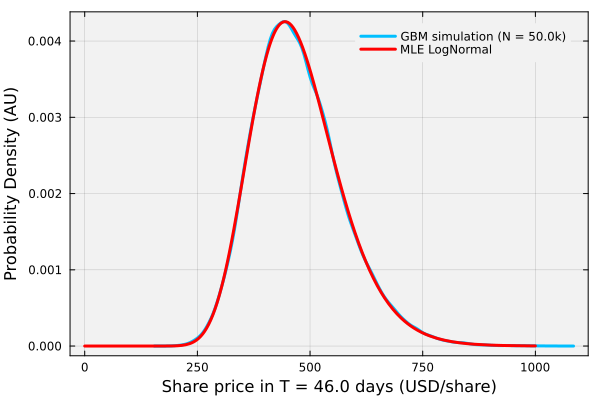

In [33]:
let
    density(endpoint_samples, lw=3, c=:deepskyblue1, label="GBM simulation (N = $(length(endpoint_samples)/1000)k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Alternative: Future share price projection using implied volatility
Alternatively, we could use the __implied volatility__ to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where the mean $\mu_{IV} = S_{0}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{0}$ for short duration contracts, and the standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{0}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). This is only an approximate model of the future share price; it has a couple of issues: 
> __Watch out!__ This model assumes a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal), which is problematic because it can emit negative share prices. One way to fix this issue is to use a [Truncated Normal distribution](https://juliastats.org/Distributions.jl/stable/truncate/#Truncated-Distributions) instead.

However, despite the potential issues, this model is __widely__ used to generate quick estimates of future share price ranges using the forward-looking implied volatility. Let's save the Normal IV distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable:

In [35]:
d_IV = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(IV/100)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 46 days`.  

> __What do we see?__ The log-normal GBM share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the Normal IV distribution (red line) is symmetric around the initial share price $S_{0}$ = `471.47 USD/share` and can admit negative share prices, albeit with a small probability.

How do the two distributions compare?

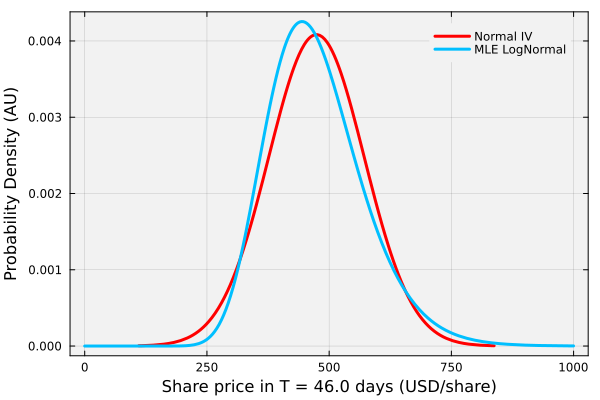

In [37]:
let
    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

## Task 3: Estimate the probability of profit and exercise for a TSLA call contract
In this task, we estimate the probability of profit of the `TSLA` contract.

> __Probability of Profit (POP)__
>
> Given the ability to simulate future share price distributions, we can now compute the likelihood of seeing a particular range of values. Let's consider this contract from the buyer's and seller's perspectives:
> * __Buyer's perspective__: the `TSLA` share price `T` days from now $S(T)$, must be _greater than_ the breakeven price $B_{c}$ for the `call` contract to be profitable. The probability of profit can be calculated from the [cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $P(S_{T}>{B}_{c}) = 1 - F_{S}(B_{c})$ where $F_{S}(B_{c})$ is the cumulative distribution function evaluated at the breakeven price.
> * __Seller's perspective__: the `TSLA` share price `T` days from now $S(T)$, must be _less than_ the breakeven price $B_{c}$ for the `call` contract to be profitable. The probability of profit can be calculated from the [complementary cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $P(S_{T}\leq{B}_{c}) = F_{S}(B_{c})$.

We can query the [cumulative distribution function $F_{S}(B_{\star})$](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the projected geometric Brownian motion distribution `d_gbm` using the [cdf(...) function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

### Probability of profit (PoP) table
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations for a `TSLA` call option using the risk-neutral geometric Brownian motion `d_gbm` price distribution.
> __Hypothesis:__ The geometric Brownian motion price distribution estimate should reproduce the reported probability of profit from both the seller's and buyer's perspective to approximately a `10%` percentage error or less in each case. Did you observe this? 

So what are the results?

In [40]:
let 

    # initialize -
    table_df = DataFrame();
    price_distribution = d_gbm; # which model are we using?

    # buyer -
    buyer_row_df = (
        sense = "buyer",
        ticker = "TSLA",
        DTE = DTE,
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_MODEL = 1 - cdf(price_distribution, B),
        POP_observed = 1 - POP,
        Δ_error_pct_gbm = (((1 - cdf(price_distribution, B)) - (1 - POP))/(1 - POP))*100

    );
    push!(table_df, buyer_row_df)
    
    # seller -
    seller_row_df = (
        sense = "seller",
        ticker = "TSLA",
        DTE = DTE,
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_MODEL = cdf(price_distribution, B),
        POP_observed = POP,
        Δ_error_pct_gbm = (((cdf(price_distribution, B)) - (POP))/(POP))*100
    );
    push!(table_df, seller_row_df);
    
    pretty_table(
        table_df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- -------- --------- --------- --------- --------- ----------- -------------- -----------------
   sense   ticker       DTE        Sₒ         K         B   POP_MODEL   POP_observed   Δ_error_pct_gbm 
  String   String   Float64   Float64   Float64   Float64     Float64        Float64           Float64 
 -------- -------- --------- --------- --------- --------- ----------- -------------- -----------------
   buyer     TSLA      46.0    471.47     485.0    519.23    0.292711         0.2937         -0.336592
  seller     TSLA      46.0    471.47     485.0    519.23    0.707289         0.7063          0.139965
 -------- -------- --------- --------- --------- --------- ----------- -------------- -----------------


### Probability of exercise and Delta
We know that $\Delta$ measures the rate of change in the option's premium $\mathcal{P}_{\tau}$ with respect to a `+1 USD/share` change in the underlying asset's price. However, one of the secret lives of $\Delta$ is its connection with the probability of exercise. Let's explore this connection.

> __Probability of Being In-the-Money (ITM)__: The absolute value of $\Delta$ can be interpreted as an estimate of the probability that an option will expire ITM. For example, a delta of 0.40 suggests a 40% chance that the option will finish ITM at expiration. If an option finishes ITM, it has intrinsic value, meaning it can be exercised for a non-zero value. Conversely, if it finishes out-of-the-money (OTM), it expires worthless.

Let's explore this idea with our `TSLA` call options by computing Delta.
* We estimate $\Delta$ using the [delta(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta). The [delta(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta) takes several arguments: the `call_option_model` instance and parameters used to compute the risk-neutral binomial share price tree, e.g., the number of tree levels `h`, the current share price `Sₒ`, the number of days to expiration `T`, etc., and returns the estimated value for Delta.

We store the estimated value for Delta in the `delta_long_call::Float64` variable.

In [42]:
delta_long_call = let

    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = call_option_model; # alias the contract model

    # call the greek function
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # return -
    greek_value;
end

0.4899999999999949

This suggests that there is approximately a $(round(delta_long_call*100, digits=0))% chance that the `TSLA` long call will finish in the money (ITM), i.e., it has a non-zero intrinsic value at expiration ($S_{T} > K$).

__From the buyer's perspective:__ The buyer needs the share price to be $S_{T} \geq K+\epsilon$ where $\epsilon > 0$ at expiration to have a __non-zero intrinsic (exercise) value__. Let's use $\epsilon=$ `0.01` USD/share. The probability of this case is given by: $P(S_{T}>(K+\epsilon)) = 1 - F_{S}(K+\epsilon)$.

In [44]:
1 - cdf(d_IV, K+(1/100)) # buyer's perspective (we could also choose d_IV here as well)

0.45529689378948646

__From the seller's perspective:__ The seller wants the option to expire out of the money (OTM), i.e., the seller gets to keep all the premium paid by the buyer. Thus, the seller wants $S_{T} \leq K$. The probability of this case is given by $P(S_{T} \leq K) = F_{S}(K)$:

In [46]:
cdf(d_IV, K)

0.5446625344434746

__The secret life of Delta:__ If $\Delta$ is the probability of being ITM, then $1-\Delta$ will be the probability of being OTM (the seller's perspective). Let's check this idea by comparing the computed probabilities of being ITM and OTM with the values derived from Delta.

In [48]:
let

    buyer_POE = delta_long_call
    seller_POE = 1 - delta_long_call
    println("Buyer Probability of Exercise (POE) estimate from Delta: $(round(buyer_POE*100,digits=2))%")
    println("Seller Probability of Exercise (POE) estimate from Delta: $(round(seller_POE*100,digits=2))%")
end

Buyer Probability of Exercise (POE) estimate from Delta: 49.0%
Seller Probability of Exercise (POE) estimate from Delta: 51.0%


___

## Summary
This example demonstrates how to compute the probability of profit for a short call option using breakeven analysis and projected share price distributions.

> __Key Takeaways:__
>
> * __Breakeven price determines profitability boundaries:__ For call options, the breakeven price equals the strike price plus the premium. Sellers profit when the share price stays below this level, while buyers profit when it exceeds this level.
> * __Two methods project future share price distributions:__ The GBM model with risk-neutral drift generates log-normally distributed share prices, while the implied volatility method constructs a Normal distribution for quick estimates. Both approaches enable probability calculations at expiration.
> * __Probability of profit connects to distribution functions:__ The CDF of the projected share price distribution at the breakeven point gives the seller's probability of profit, while one minus the CDF gives the buyer's probability of profit. Delta provides an alternative estimate of the probability of finishing in the money.

Understanding probability of profit calculations enables better assessment of option contract risk and reward potential.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.